In [1]:
import  sys
sys.path = ['/data/xianliang/project_ctaintern/']+sys.path

import pandas as pd
import matplotlib.pyplot as plt
import pyelf.elutil as eu
import numpy as np
import datetime
import os
import pyelf.commodity_list as commlist

import Tools.MLTools as mltool
from typing import Tuple

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

print(plt.style.available)
plt.style.use('seaborn')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
outdir = '/data/xianliang/CTA/Exp-Demo/'
mltool.myMakeDir(outdir)
figpath = os.path.join(outdir, 'FactorExploration-Arbitrage')

In [4]:
df = mltool.LoadData('/mnt/Data4t/xiaowei/final_data/hc_rb_1min.csv')
df.tail()

,date,time,O,H,L,C,O_p1,H_p1,L_p1,C_p1,...,I_p1,turnover_p1,O_p2,H_p2,L_p2,C_p2,V_p2,I_p2,turnover_p2,datetime.1
index,,,,,,,,,,,,,,,,,,,,,
2023-03-14 14:55:00,20230314,1455,100.0,100.0,95.0,97.0,4469.0,4469.0,4463.0,4465.0,...,911246.0,188967230.0,4369.0,4371.0,4366.0,4368.0,15841.0,2008216.0,691946210.0,2023-03-14 14:55:00
2023-03-14 14:56:00,20230314,1456,97.0,99.0,96.0,98.0,4465.0,4466.0,4460.0,4464.0,...,910239.0,118795500.0,4368.0,4369.0,4362.0,4366.0,15454.0,2006417.0,674565180.0,2023-03-14 14:56:00
2023-03-14 14:57:00,20230314,1457,98.0,99.0,96.0,98.0,4465.0,4468.0,4464.0,4466.0,...,909587.0,98548880.0,4367.0,4370.0,4367.0,4368.0,9825.0,2004201.0,429152120.0,2023-03-14 14:57:00
2023-03-14 14:58:00,20230314,1458,97.0,99.0,95.0,96.0,4465.0,4468.0,4464.0,4468.0,...,908749.0,90556620.0,4368.0,4372.0,4367.0,4372.0,12696.0,2002711.0,554664960.0,2023-03-14 14:58:00
2023-03-14 14:59:00,20230314,1459,97.0,99.0,91.0,96.0,4468.0,4470.0,4465.0,4469.0,...,908211.0,147686300.0,4371.0,4374.0,4371.0,4373.0,13173.0,1999213.0,575971100.0,2023-03-14 14:59:00


<AxesSubplot:xlabel='index'>

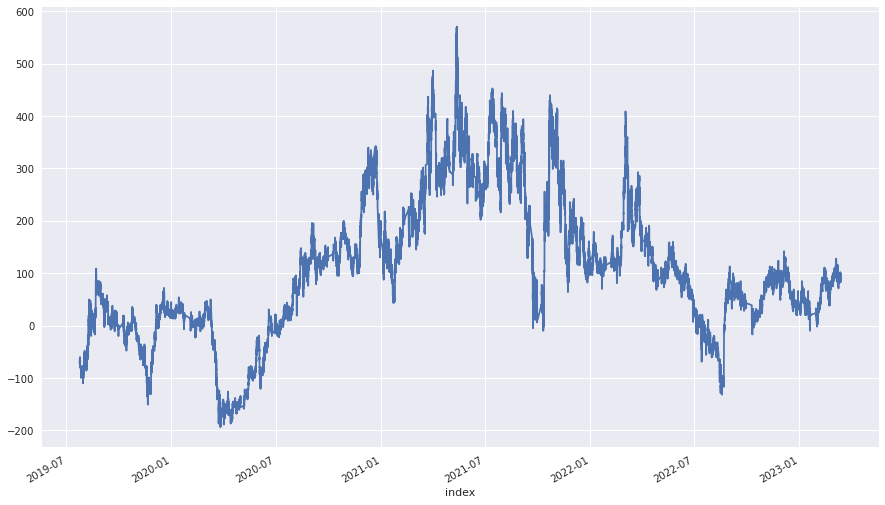

In [5]:
df['C'].plot(figsize=(15,9))

读入数据——使用指数数据产生交易信号, 主力后复权数据回测

In [17]:
'''
使用指数数据产生交易信号, 主力后复权数据回测
'''
period = 5
cperiod = 5
dayed_time = datetime.time(15,0)
comms = commlist.comms_all
date_b = datetime.datetime(2016,1,1)

datadir = '/data/xianliang/project_ctaintern/data2016_left/index/'
data_index = mltool.CTA_LoadData_AutoFactor(datadir,period,aux_cols=['if_jy','amount','twap','vwap'],date_b=date_b,cols=comms,ref_ind=None,if_parquet=True)

datadir = '/data/xianliang/project_ctaintern/data2016_left/zl/'
data_zl = mltool.CTA_LoadData_AutoFactor(datadir,period,aux_cols=['if_jy','amount','twap','vwap'],date_b=date_b,cols=comms,ref_ind=data_index['C'].index,if_parquet=True)

O = data_index['O'].copy()
C = data_index['C'].copy()
H = data_index['H'].copy()
L = data_index['L'].copy()
V = data_index['V'].copy()
I = data_index['I'].copy()
amount = data_index['amount'].copy()
if_jy = data_index['if_jy'].copy()


设计跨品种套利数据结构

In [4]:

class ArbTwo:
    '''
    实现2品种 价差对/比价, 并设置真实交易手数
    ex: pp-3ma 产生价差对, 交易设置 2pp vs 3ma
    '''
    def __init__(self):
        self.name = ''
        self.symbol1 = 'pp'
        self.symbol2 = 'ma'
        self.ratio1 = 1 
        self.ratio2 = 3
        self.arblogic = 'sub' ### sub: pp-3ma; div: pp/3ma
        self.lots_mode = 0 ### 0-rebalance lots every trade; 1-use lots1, lots2 pre-defined
        self.lots1 = 2
        self.lots2 = 3

    def set_para(self, symbol1, symbol2, ratio1=1, ratio2=1, arblogic='sub', lots_mode=0, lots1=1, lots2 = 1):
        self.name = '%s-%s'%(symbol1, symbol2) if arblogic=='sub' else '%s/%s'%(symbol1, symbol2)
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.ratio1 = ratio1 
        self.ratio2 = ratio2
        self.arblogic = arblogic
        self.lots_mode = lots_mode
        self.lots1 = lots1
        self.lots2 = lots2

选择套利品种对

In [5]:
arbtwo_list = list()

pair1 = ArbTwo()
pair1.set_para('hc','rb',1,1,'sub',1,1,1)

pair2 = ArbTwo()
pair2.set_para('rb','i',1,1,'div',0)

pair3 = ArbTwo()
pair3.set_para('c','cs',1,1,'sub',1,1,1)

pair4 = ArbTwo()
pair4.set_para('yy','m',1,1,'div',0)

pair5 = ArbTwo()
pair5.set_para('oi','rm',1,1,'div',0)

pair6 = ArbTwo()
pair6.set_para('m','rm',1,1,'sub',1,1,1)

pair7 = ArbTwo()
pair7.set_para('oi','yy',1,1,'sub',1,1,1)

pair8 = ArbTwo()
pair8.set_para('yy','p',1,1,'sub',1,1,1)

pair9 = ArbTwo()
pair9.set_para('ss','ni',1,1,'div',0)

pair10 = ArbTwo()
pair10.set_para('pp','ma',1,3,'sub',1,2,3)

pair11 = ArbTwo()
pair11.set_para('pf','ta',1,1,'div',0)

pair12 = ArbTwo()
pair12.set_para('lu','fu',1,1,'sub',1,1,1)

pair13 = ArbTwo()
pair13.set_para('ru','nr',1,1,'sub',1,1,1)

pair14 = ArbTwo()
pair14.set_para('pp','l',1,1,'sub',1,1,1)

arbtwo_list.append(pair1)
arbtwo_list.append(pair2)
arbtwo_list.append(pair3)
arbtwo_list.append(pair4)
arbtwo_list.append(pair5)
arbtwo_list.append(pair6)
arbtwo_list.append(pair7)
arbtwo_list.append(pair8)
arbtwo_list.append(pair9)
arbtwo_list.append(pair10)
arbtwo_list.append(pair11)
arbtwo_list.append(pair12)
arbtwo_list.append(pair13)
arbtwo_list.append(pair14)

生成套利价差/比价数据

In [29]:

def GenerateArbData(pair:ArbTwo, data):
    arbdata_dict = {}
    arbdata_dict['name'] = pair.name
    for icol in ['O','H','L','C']:
        if pair.arblogic=='sub':
            arbdata_dict[icol] = pair.ratio1*data[icol][pair.symbol1]-pair.ratio2*data[icol][pair.symbol2]
        elif pair.arblogic=='div':
            arbdata_dict[icol] = (pair.ratio1*data[icol][pair.symbol1])/(pair.ratio2*data[icol][pair.symbol2])
    return arbdata_dict


def ts_res(series_y, series_x, period, maperiod=1):
    '''
    beta = cov(x,y)/var(x)
    alpha = avg(y)-beta*avg(x)
    residual = y-(beta*x+alpha)
    '''
    beta = series_y.rolling(period).cov(series_x) / series_x.rolling(period).var()

    avg_y = series_y.rolling(period).mean()
    avg_x = series_x.rolling(period).mean()
    alpha = avg_y - beta * avg_x
    # res = series_y - (beta.rolling(window=maperiod,min_periods=1).mean() * series_x + alpha.rolling(window=maperiod,min_periods=1).mean())
    res = series_y - (beta.ewm(maperiod).mean() * series_x + alpha.ewm(maperiod).mean())
    
    return res

def GenerateArbDataReg(pair:ArbTwo, data, roll_period=64, maperiod=1):
    arbdata_dict = {}
    arbdata_dict['name'] = pair.name
    for icol in ['O','H','L','C']:
        arbdata_dict[icol] = ts_res(data[icol][pair.symbol1], data[icol][pair.symbol2], roll_period, maperiod)+0.5*(pair.ratio1*data[icol][pair.symbol1].mean()+pair.ratio2*data[icol][pair.symbol2].mean())
    for icol in list(data.keys()):
        if icol=='period':
            continue
        arbdata_dict['%s_1'%icol] = data[icol][pair.symbol1]
        arbdata_dict['%s_2'%icol] = data[icol][pair.symbol2]
    return arbdata_dict

<AxesSubplot:title={'center':'hc-rb'}, xlabel='index'>

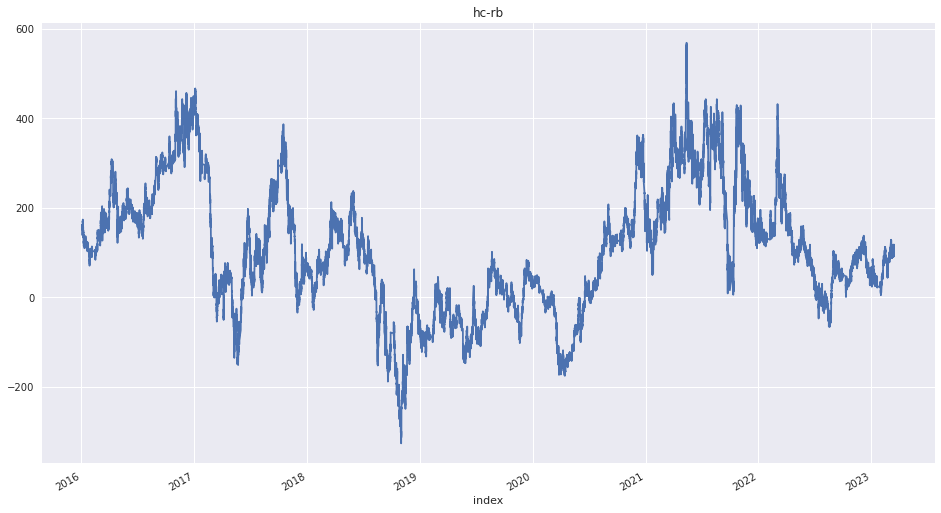

In [26]:
pair1_data = GenerateArbData(pair1, data_index)
pair1_data['C'].plot(figsize=(16,9), title=pair1_data['name'])

<AxesSubplot:title={'center':'rb/i'}, xlabel='index'>

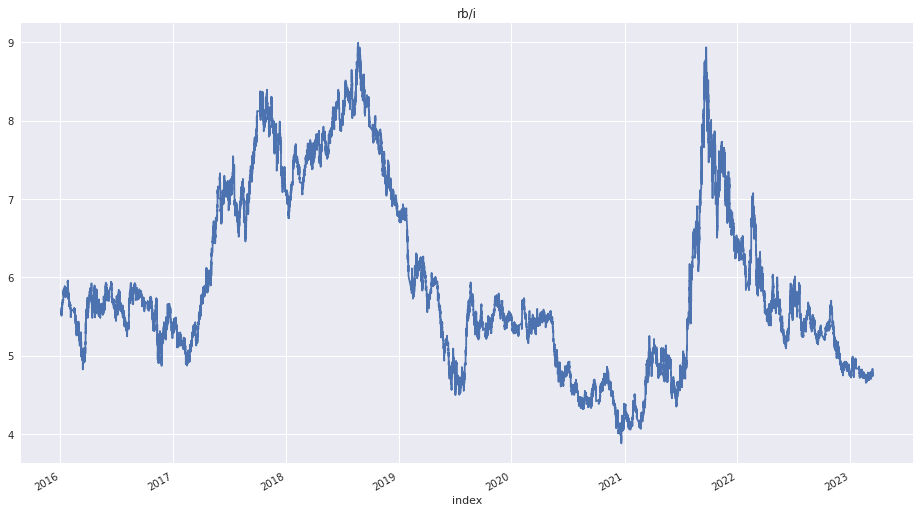

In [30]:
pair2_data = GenerateArbData(pair2, data_index)
pair2_data['C'].plot(figsize=(16,9), title=pair2_data['name'])


In [31]:
results_arbdata = eu.multiprocess(GenerateArbData, paras=arbtwo_list, n_processes=min(50, len(arbtwo_list)), data=data_index.copy())

时序CTA交易套利对

In [37]:

def ArbStrategy_BBandRev(data_arb, para):
    period, nstd = para

    CC = data_arb['C']

    midline = CC.rolling(window=period).mean()
    upbound = CC.rolling(window=period).mean()+nstd*CC.rolling(window=period).std()
    dnbound = CC.rolling(window=period).mean()-nstd*CC.rolling(window=period).std()

    bsig0 = CC.values<dnbound.values
    ssig0 = CC.values>upbound.values

    ps0 = eu.get_ps(1*bsig0, 1*ssig0, 0*bsig0)

    C01 = (ps0==1) & eu.cross(CC.values, midline.values)
    C02 = (ps0==-1) & eu.cross(midline.values, CC.values)
    csig = (C01 | C02)

    ps = eu.get_ps(1*bsig0, 1*ssig0, 1*csig)

    return pd.Series(ps, index=CC.index)

def ArbStrategy_BBandTrend(data_arb, para):
    period, nstd = para

    CC = data_arb['C']

    midline = CC.rolling(window=period).mean()
    upbound = CC.rolling(window=period).mean()+nstd*CC.rolling(window=period).std()
    dnbound = CC.rolling(window=period).mean()-nstd*CC.rolling(window=period).std()


    bsig0 = CC.values>upbound.values
    ssig0 = CC.values<dnbound.values

    ps0 = eu.get_ps(1*bsig0, 1*ssig0, 0*bsig0)

    C01 = (ps0==1) & eu.cross(CC.values, midline.values)
    C02 = (ps0==-1) & eu.cross(midline.values, CC.values)
    csig = (C01 | C02)

    ps = eu.get_ps(1*bsig0, 1*ssig0, 1*csig)

    return pd.Series(ps, index=CC.index)

<AxesSubplot:xlabel='index'>

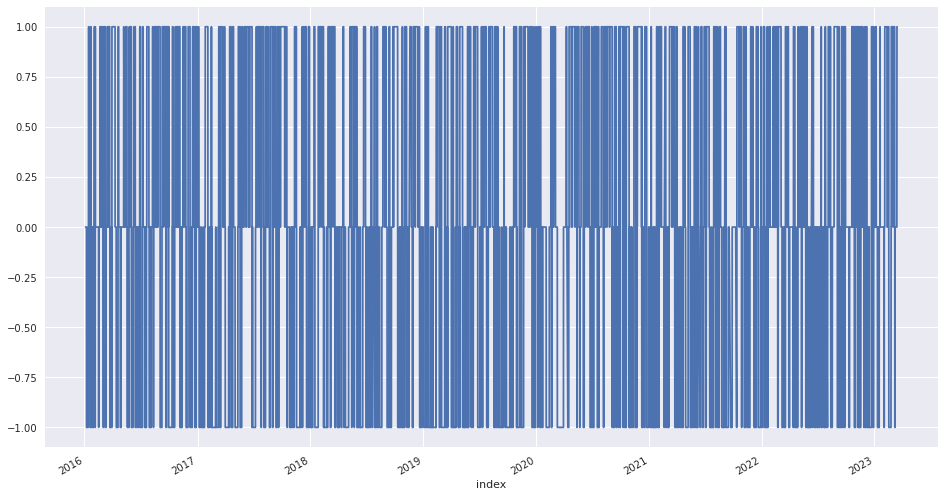

In [38]:
# pair1_ps = ArbStrategy_BBandRev(pair1_data, (256, 2))
pair1_ps = ArbStrategy_BBandTrend(pair1_data, (256, 2))
pair1_ps.plot(figsize=(16,9))

In [33]:
para_bbandrev = (256, 2)
results_ps = eu.multiprocess(ArbStrategy_BBandRev, paras=results_arbdata, n_processes=min(50, len(results_arbdata)), para=para_bbandrev)

回测backtest

In [19]:
def ArbBacktest(para_bkt:Tuple[pd.Series, ArbTwo], data):
    ps_pair, pair = para_bkt
    psdf = pd.DataFrame(index=ps_pair.index)
    if pair.lots_mode==0:
        psdf[pair.symbol1] = ps_pair
        psdf[pair.symbol2] = -ps_pair

        scomms = [pair.symbol1, pair.symbol2]

        data_bkt = {}
        data_bkt['C'] = data['C'][scomms]

        dfbkt = mltool.GetMinProfit(psdf, data_bkt, scomms, cost_penalty=1, if_pct=True)
    elif pair.lots_mode==1:
        psdf[pair.symbol1] = pair.lots1*ps_pair
        psdf[pair.symbol2] = -pair.lots2*ps_pair

        scomms = [pair.symbol1, pair.symbol2]

        data_bkt = {}
        data_bkt['C'] = data['C'][scomms]

        dfbkt = mltool.GetMinProfit(psdf, data_bkt, scomms, cost_penalty=1, if_pct=False)
    return dfbkt

In [39]:
dfbkt = ArbBacktest((pair1_ps, pair1), data_zl)
dfbkt.tail()

,close_hc,ps_hc,GP_hc,cost_hc,NP_hc,close_rb,ps_rb,GP_rb,cost_rb,NP_rb,TN,TradeN,GrossProfit,cost,Profit
index,,,,,,,,,,,,,,,
2023-03-15 14:35:00,9609.975934,1.0,44951.380125,17085.0,27866.380125,5937.376126,-1.0,-29379.934287,11390.0,-40769.934287,2,2.0,7785.722919,14237.5,-6451.777081
2023-03-15 14:40:00,9609.975934,1.0,44951.380125,17085.0,27866.380125,5937.376126,-1.0,-29379.934287,11390.0,-40769.934287,2,2.0,7785.722919,14237.5,-6451.777081
2023-03-15 14:45:00,9609.975934,1.0,44951.380125,17085.0,27866.380125,5937.376126,-1.0,-29379.934287,11390.0,-40769.934287,2,2.0,7785.722919,14237.5,-6451.777081
2023-03-15 14:50:00,9609.975934,1.0,44951.380125,17085.0,27866.380125,5937.376126,-1.0,-29379.934287,11390.0,-40769.934287,2,2.0,7785.722919,14237.5,-6451.777081
2023-03-15 14:55:00,9609.975934,1.0,44951.380125,17085.0,27866.380125,5937.376126,-1.0,-29379.934287,11390.0,-40769.934287,2,2.0,7785.722919,14237.5,-6451.777081


('sr: ', -0.23253772637804918)


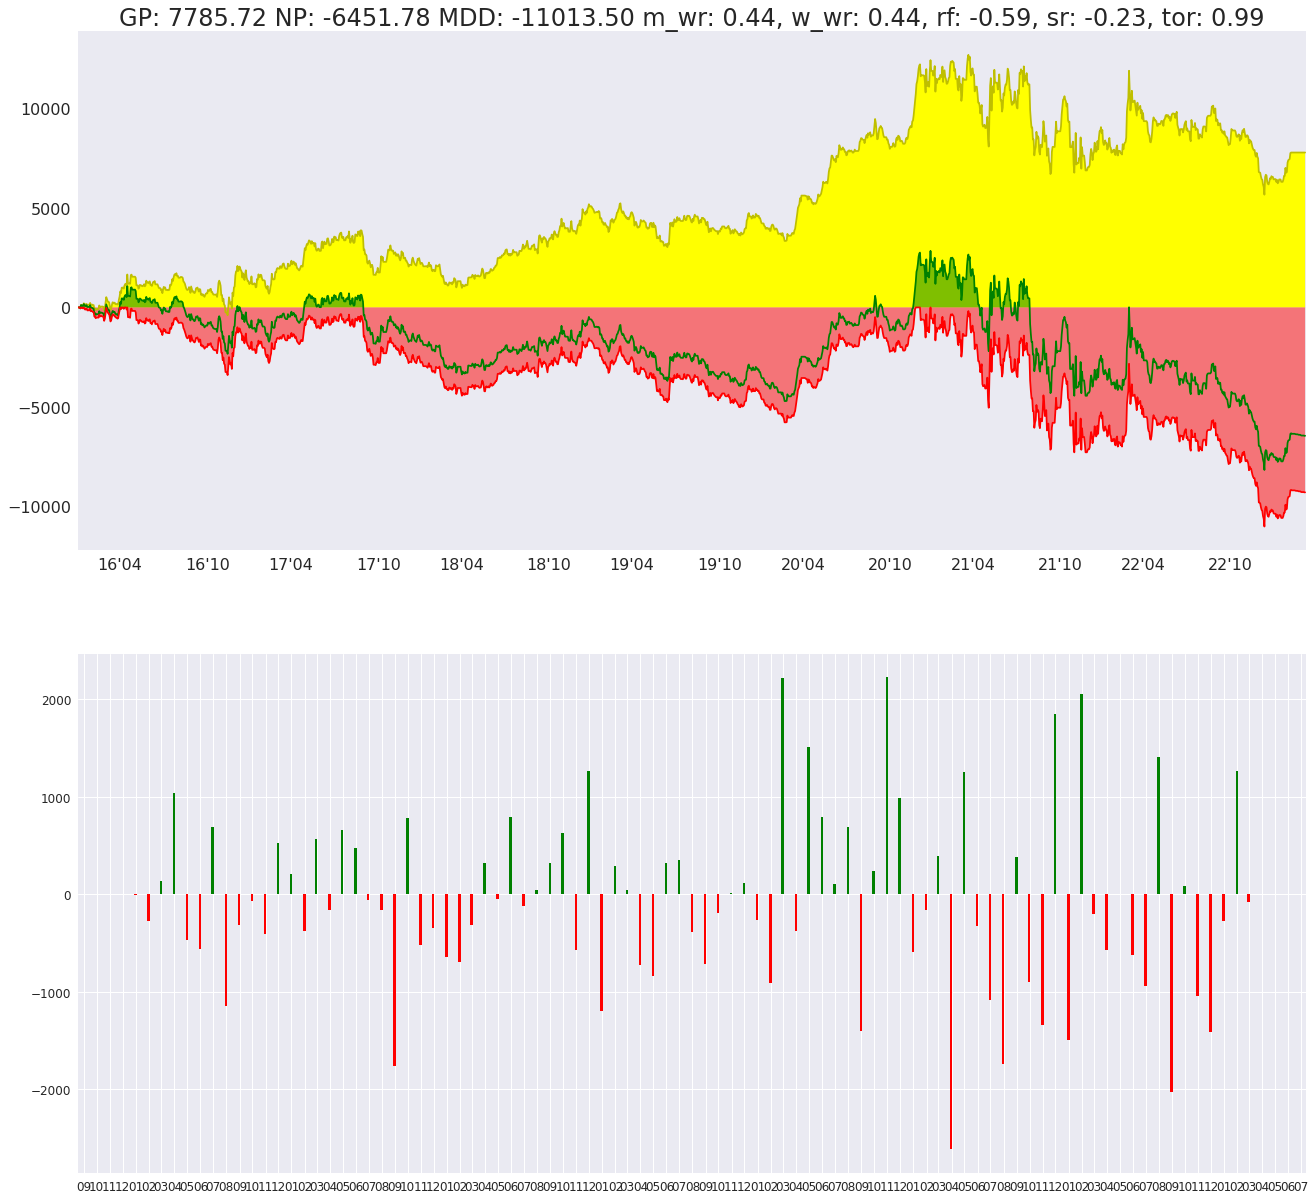

(-0.23253772637804918, 0.9932406141711945)

In [40]:
'''
画图
'''
comms_bkt = [pair1.symbol1, pair1.symbol2]
mltool.PlotPerformance(dfbkt, comms_bkt, figpath, nameflag_='BKT-%s'%pair1.name, enddate=datetime.datetime(2016,1,1))

In [36]:
allparas = list(zip(results_ps, arbtwo_list))
results_bkt = eu.multiprocess(ArbBacktest, paras=allparas, n_processes=min(50, len(allparas)), data=data_zl.copy())

处理百分比回测绝对数值回测差异？
组合内不同品种对资金管理rebalance？